In [2]:
import os
import logging
import time
import psycopg2

import pandas as pd
import numpy as np 
from sqlalchemy import create_engine

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
 

def connect_postgres():
    database = os.environ['POSTGRES_DB']
    user = os.environ['POSTGRES_USER']
    password = os.environ['POSTGRES_PASSWORD']
    host = os.environ['POSTGRES_SERVER']
    port = 5432

    exc, conn, engine = None, None, None

    for _ in range(5):
        try:
            conn = psycopg2.connect(
                database=database, user=user, password=password, host=host, port=port)
        except Exception as e:
            logging.warning("Error connecting to postgres, will retry in 3 sec: %s", e)
            time.sleep(3)
            exc = e
        else:
            logging.info("Connected...")
            logging.info("Everything goes well from Postgres, you're a fu*** pro...")
            
            engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                user, password, host, port, database
            ))
            break
    else:
        logging.error("Unable to connect to  %s DB", database)
        raise exc
    
    return [conn, engine]


In [3]:
[conn, engine] = connect_postgres()

INFO:root:Connected...
INFO:root:Everything goes well from Postgres, you're a fu*** pro...


In [4]:
df_iss = pd.read_sql("""
SELECT
	copytransaction.id, title_name, code, trans_copy_code_id, trans_tittle_code_id, trans_date_id as date_iss
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date, public.title
WHERE
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3140' AND
	trans_type_code IN ('ISS') AND
    trans_tittle_code_id = title.id AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code, id, title_name

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
df_ret = pd.read_sql("""
SELECT
    trans_copy_code_id, trans_tittle_code_id, title_name, code, trans_date_id as date_ret
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date, public.title
WHERE
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3140' AND
	trans_type_code IN ('RET') AND
    trans_tittle_code_id = title.id AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code, copy.id, title_name

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
df_iss = df_iss.reset_index(drop=True)
df_iss

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss
0,939673,Cultivos hidropónicos,199000484,12220,7505,20000505
1,1144407,Utilizacion intensiva de pasturas,199000484,15765,9844,20010326
2,1120000,Fundamentos de ecología,199000484,16885,10493,20010326
3,5938073,Quimica de los productos naturales,199000484,25511,15780,20010307
4,1221830,Ictiología,199000484,75242,50357,20011022
...,...,...,...,...,...,...
112308,8759502,Química,201871097,602516,595253,20180206
112309,8775164,Química,201880026,823259,827814,20180307
112310,9126827,Química,201880026,832497,768913,20180305
112311,9143035,Química,201880026,834960,827814,20180313


In [7]:
df_ret = df_ret.reset_index(drop=True)
df_ret

,trans_copy_code_id,trans_tittle_code_id,title_name,code,date_ret
0,12220,7505,Cultivos hidropónicos,199000484,20000505
1,15765,9844,Utilizacion intensiva de pasturas,199000484,20010326
2,16885,10493,Fundamentos de ecología,199000484,20010331
3,25511,15780,Quimica de los productos naturales,199000484,20010307
4,75242,50357,Ictiología,199000484,20011106
...,...,...,...,...,...
112927,602516,595253,Química,201871097,20180206
112928,823259,827814,Química,201880026,20180308
112929,832497,768913,Química,201880026,20180306
112930,834960,827814,Química,201880026,20180314


In [8]:
df_iss = df_iss.astype({col: 'int32' for col in df_iss.select_dtypes('int64').columns})
df_iss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112313 entries, 0 to 112312
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    112313 non-null  int32 
 1   title_name            112313 non-null  object
 2   code                  112313 non-null  int32 
 3   trans_copy_code_id    112313 non-null  int32 
 4   trans_tittle_code_id  112313 non-null  int32 
 5   date_iss              112313 non-null  int32 
dtypes: int32(5), object(1)
memory usage: 3.0+ MB


In [9]:
df_ret = df_ret.astype({col: 'int32' for col in df_ret.select_dtypes('int64').columns})
df_ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112932 entries, 0 to 112931
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   trans_copy_code_id    112932 non-null  int32 
 1   trans_tittle_code_id  112932 non-null  int32 
 2   title_name            112932 non-null  object
 3   code                  112932 non-null  int32 
 4   date_ret              112932 non-null  int32 
dtypes: int32(4), object(1)
memory usage: 2.6+ MB


In [10]:
df = df_iss.merge(df_ret, how='left', on=['code','trans_copy_code_id', 'trans_tittle_code_id', 'title_name'])
df['diff'] = df['date_ret'] - df['date_iss']
df = df[df['diff'] >= 0]
df = df.sort_values(
    ['trans_tittle_code_id', 'diff']
)
df

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss,date_ret,diff
38427,1197135,Introduccion a la teoria general de los sistemas,199831258,30,25,20010813,20011008.0,195.0
56376,2150089,La imagen fílmica,200129573,31,29,20050114,20050131.0,17.0
106311,3179130,Algunas tecnicas de la investigacion de operac...,200623064,46,44,20070222,20070327.0,105.0
32374,1036765,Ideas fundamentales sobre la teoria de la info...,199828421,65,60,20001102,20001115.0,13.0
8072,737758,Las computadoras y la información : introducción,199425647,106,86,19980421,19980421.0,0.0
...,...,...,...,...,...,...,...,...
165968,8822358,El diario de Ana Frank,201228713,914579,927068,20180227,20180315.0,88.0
196697,9129768,El espejismo de Dios,201628873,914125,930381,20180220,20180220.0,0.0
196696,8822087,El espejismo de Dios,201628873,914125,930381,20180205,20180220.0,15.0
204249,9125968,Florence Foster Jenkins [videograbación],201825203,916547,932527,20180214,20180214.0,0.0


In [11]:
df.columns

Index(['id', 'title_name', 'code', 'trans_copy_code_id',
       'trans_tittle_code_id', 'date_iss', 'date_ret', 'diff'],
      dtype='object')

In [12]:
df['ISS'] = pd.to_datetime(df['date_iss'].astype(str), format='%Y%m%d') 
df['RET'] = pd.to_datetime(df['date_ret'].astype(str), format='%Y%m%d')
df['trans_copy_code_id'] = df['trans_copy_code_id'].astype(str)
df['trans_tittle_code_id'] = df['trans_tittle_code_id'].astype(str)
df['duration'] = df['RET'] - df['ISS'] + pd.Timedelta(days=1)
df['duration'] = df['duration'].dt.days
df

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss,date_ret,diff,ISS,RET,duration
38427,1197135,Introduccion a la teoria general de los sistemas,199831258,30,25,20010813,20011008.0,195.0,2001-08-13,2001-10-08,57
56376,2150089,La imagen fílmica,200129573,31,29,20050114,20050131.0,17.0,2005-01-14,2005-01-31,18
106311,3179130,Algunas tecnicas de la investigacion de operac...,200623064,46,44,20070222,20070327.0,105.0,2007-02-22,2007-03-27,34
32374,1036765,Ideas fundamentales sobre la teoria de la info...,199828421,65,60,20001102,20001115.0,13.0,2000-11-02,2000-11-15,14
8072,737758,Las computadoras y la información : introducción,199425647,106,86,19980421,19980421.0,0.0,1998-04-21,1998-04-21,1
...,...,...,...,...,...,...,...,...,...,...,...
165968,8822358,El diario de Ana Frank,201228713,914579,927068,20180227,20180315.0,88.0,2018-02-27,2018-03-15,17
196697,9129768,El espejismo de Dios,201628873,914125,930381,20180220,20180220.0,0.0,2018-02-20,2018-02-20,1
196696,8822087,El espejismo de Dios,201628873,914125,930381,20180205,20180220.0,15.0,2018-02-05,2018-02-20,16
204249,9125968,Florence Foster Jenkins [videograbación],201825203,916547,932527,20180214,20180214.0,0.0,2018-02-14,2018-02-14,1


In [13]:
df.describe()

,id,code,date_iss,date_ret,diff,duration
count,1.590280e+05,1.590280e+05,1.590280e+05,1.590280e+05,159028.000000,159028.000000
mean,4.183980e+06,2.005615e+08,2.007310e+07,2.007440e+07,1296.869514,49.712717
std,2.627461e+06,6.576399e+05,5.714370e+04,5.704871e+04,4467.964490,146.307744
min,9.220000e+02,1.990005e+08,1.997033e+07,1.997033e+07,0.000000,1.000000
25%,1.904968e+06,1.999288e+08,2.003092e+07,2.003103e+07,0.000000,1.000000
50%,3.976784e+06,2.005333e+08,2.007053e+07,2.007071e+07,4.000000,5.000000
75%,6.388491e+06,2.011230e+08,2.012091e+07,2.012100e+07,100.000000,29.000000
max,9.222933e+06,2.018800e+08,2.018032e+07,2.018032e+07,99891.000000,3615.000000


In [14]:
df[df['duration'] <= 100].sort_values('duration')

,id,title_name,code,trans_copy_code_id,trans_tittle_code_id,date_iss,date_ret,diff,ISS,RET,duration
204760,9129666,Game of thrones,201870983,916570,932545,20180214,20180214.0,0.0,2018-02-14,2018-02-14,1
62269,1800189,Zoología de los invertebrados,200227495,217064,162702,20040421,20040421.0,0.0,2004-04-21,2004-04-21,1
62953,1708809,Zoología de los invertebrados,200229850,215337,162702,20040205,20040205.0,0.0,2004-02-05,2004-02-05,1
66485,1554054,Zoología de los invertebrados,200236328,215337,162702,20030830,20030830.0,0.0,2003-08-30,2003-08-30,1
66491,1558376,Zoología de los invertebrados,200236328,217063,162702,20030917,20030917.0,0.0,2003-09-17,2003-09-17,1
...,...,...,...,...,...,...,...,...,...,...,...
24153,632741,Diccionario de quimica y de productos quimicos,199715465,131523,99127,19980121,19980430.0,309.0,1998-01-21,1998-04-30,100
24154,632741,Diccionario de quimica y de productos quimicos,199715465,131523,99127,19980121,19980430.0,309.0,1998-01-21,1998-04-30,100
201506,8800388,Biology of plants,201730645,689371,697571,20170829,20171206.0,377.0,2017-08-29,2017-12-06,100
46468,1302661,Fisiología vegetal,199926155,163044,122524,20020411,20020719.0,308.0,2002-04-11,2002-07-19,100


In [15]:
df = df[df['duration'] <= 100].sort_values('duration')

In [16]:
df_titles = df[['trans_tittle_code_id', 'title_name']]
df_titles = df_titles.set_index('trans_tittle_code_id')
df_titles

,title_name
trans_tittle_code_id,
932545,Game of thrones
162702,Zoología de los invertebrados
162702,Zoología de los invertebrados
162702,Zoología de los invertebrados
162702,Zoología de los invertebrados
...,...
99127,Diccionario de quimica y de productos quimicos
99127,Diccionario de quimica y de productos quimicos
697571,Biology of plants


In [17]:
df_new = df.drop(['code', 'trans_copy_code_id', 'date_iss', 'id', 'date_ret', 'diff', 'ISS', 'RET'], axis=1)
df_new = df_new.groupby(['trans_tittle_code_id'])['duration'].agg(
    borrow_days='sum',
    borrow_numbers='count',
).sort_values(
    ['borrow_days', 'borrow_numbers']
).reset_index()
df_new['score'] = df_new['borrow_days'] * df_new['borrow_numbers']
df_new = df_new.set_index('trans_tittle_code_id')
# df_new = df_new.loc[(df_new['borrow_days']  <= 10950)] # past 30 years
df_new

,borrow_days,borrow_numbers,score
trans_tittle_code_id,,,
100009,1,1,1
100017,1,1,1
10019,1,1,1
10031,1,1,1
100448,1,1,1
...,...,...,...
617135,29526,2334,68913684
119893,30568,1940,59301920
563210,31122,1797,55926234


In [18]:
df_new.describe()

,borrow_days,borrow_numbers,score
count,19614.000000,19614.000000,1.961400e+04
mean,102.277200,7.276537,4.325746e+04
std,762.337108,57.972566,1.319739e+06
min,1.000000,1.000000,1.000000e+00
25%,3.000000,1.000000,4.000000e+00
50%,17.000000,1.000000,2.100000e+01
75%,52.000000,3.000000,1.040000e+02
max,38580.000000,2767.000000,1.067509e+08


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

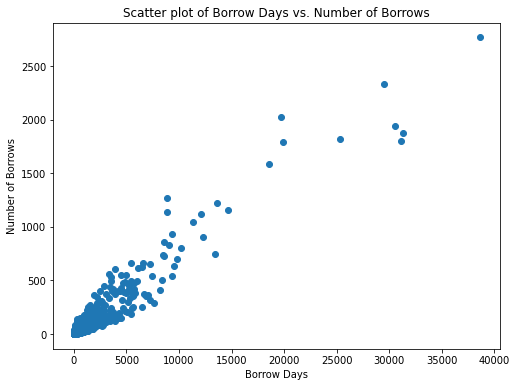

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(df_new.borrow_days, df_new.borrow_numbers)
plt.xlabel('Borrow Days')
plt.ylabel('Number of Borrows')
plt.title('Scatter plot of Borrow Days vs. Number of Borrows')
plt.show()

In [21]:
# Import the sklearn function
from sklearn.preprocessing import StandardScaler

columns = df_new.columns
data_to_standardize = df_new[columns]
scaler = StandardScaler().fit(data_to_standardize)

# Standardize the columns.
standardized_data = df_new.copy()
standardized_columns = scaler.transform(data_to_standardize)
standardized_data[columns] = standardized_columns

standardized_data

,borrow_days,borrow_numbers,score
trans_tittle_code_id,,,
100009,-0.132854,-0.108270,-0.032777
100017,-0.132854,-0.108270,-0.032777
10019,-0.132854,-0.108270,-0.032777
10031,-0.132854,-0.108270,-0.032777
100448,-0.132854,-0.108270,-0.032777
...,...,...,...
617135,38.597718,40.135929,52.186226
119893,39.964602,33.339437,44.902959
563210,40.691334,30.872690,42.345049


In [22]:
standardized_data.describe()

,borrow_days,borrow_numbers,score
count,19614.000000,19614.000000,1.961400e+04
mean,0.000000,0.000000,-5.796209e-18
std,1.000025,1.000025,1.000025e+00
min,-0.132854,-0.108270,-3.277737e-02
25%,-0.130231,-0.108270,-3.277509e-02
50%,-0.111866,-0.108270,-3.276221e-02
75%,-0.065953,-0.073770,-3.269932e-02
max,50.474657,47.605169,8.085716e+01


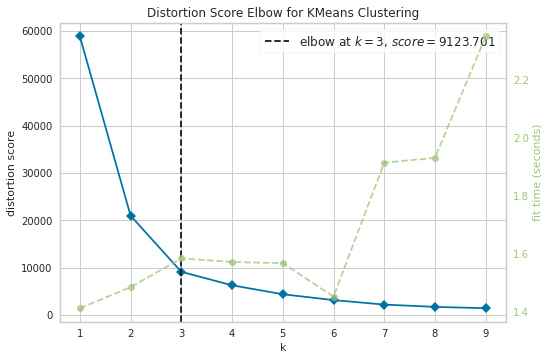

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(init='k-means++', random_state=540)
visualizer = KElbowVisualizer(km, k=(1,10))
 
visualizer.fit(standardized_data)
visualizer.show()

In [24]:
# Train a Kmeans instance
n_clusters = visualizer.elbow_value_

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=540)
kmeans.fit(standardized_data)
clusters = kmeans.predict(standardized_data)
df_new['cluster'] = clusters


df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('int64').columns})
df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('float64').columns})
df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('bool').columns})

df_new

,borrow_days,borrow_numbers,score,cluster
trans_tittle_code_id,,,,
100009,1,1,1,0
100017,1,1,1,0
10019,1,1,1,0
10031,1,1,1,0
100448,1,1,1,0
...,...,...,...,...
617135,29526,2334,68913684,1
119893,30568,1940,59301920,1
563210,31122,1797,55926234,1


In [25]:
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

pca = PCA(n_components=2)

reduced_X = pd.DataFrame(pca.fit_transform(standardized_data), columns=["PC1", "PC2"])
reduced_X

,PC1,PC2
0,-0.159452,0.066452
1,-0.159452,0.066452
2,-0.159452,0.066452
3,-0.159452,0.066452
4,-0.159452,0.066452
...,...,...
19609,75.383852,11.570994
19610,68.133705,8.407398
19611,65.685856,7.257017
19612,67.715900,8.226732


In [26]:
reduced_X['cluster'] = clusters
reduced_X

,PC1,PC2,cluster
0,-0.159452,0.066452,0
1,-0.159452,0.066452,0
2,-0.159452,0.066452,0
3,-0.159452,0.066452,0
4,-0.159452,0.066452,0
...,...,...,...
19609,75.383852,11.570994,1
19610,68.133705,8.407398,1
19611,65.685856,7.257017,1
19612,67.715900,8.226732,1


/opt/app/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


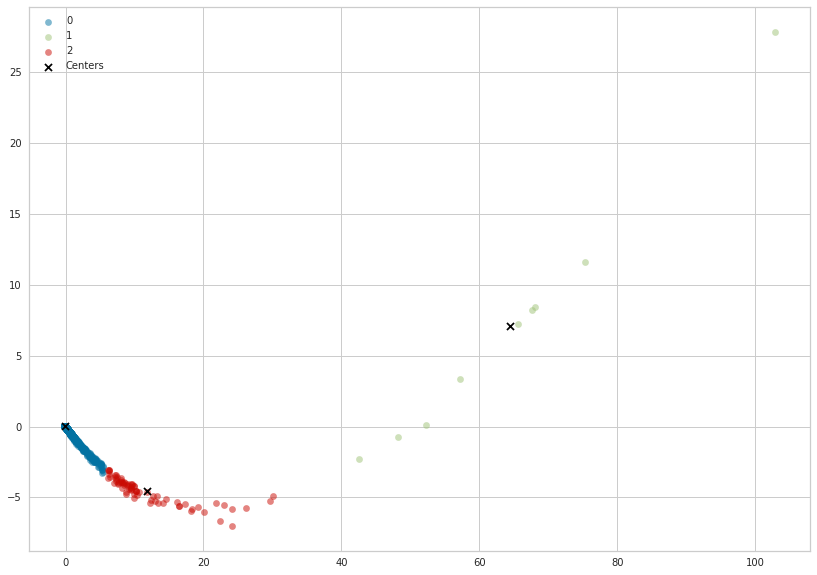

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

reduced_centers = pca.transform(kmeans.cluster_centers_)

for cluster in range(0, n_clusters):
    plt.scatter(
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC1'],
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC2'], 
        label=cluster, alpha=0.5, s=40
    )

plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], marker='x', label='Centers', c="black", s=50)
plt.legend()
plt.show()

In [28]:
number_clusters = df_new['cluster'].value_counts()

In [29]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19614 entries, 100009 to 457838
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   borrow_days     19614 non-null  int32
 1   borrow_numbers  19614 non-null  int32
 2   score           19614 non-null  int32
 3   cluster         19614 non-null  int32
dtypes: int32(4)
memory usage: 975.7+ KB


In [30]:
df_final = pd.merge(
    df_new, df_titles, on=['trans_tittle_code_id']
).drop_duplicates()
df_final

,borrow_days,borrow_numbers,score,cluster,title_name
trans_tittle_code_id,,,,,
100009,1,1,1,0,Sociedades en mutacion
100017,1,1,1,0,El imperio romano
10019,1,1,1,0,Contaminacion atmosferica
10031,1,1,1,0,Contribucion al reconocimiento bioecologico de...
100448,1,1,1,0,Corrosión y protección metálicas
...,...,...,...,...,...
617135,29526,2334,68913684,1,Bioquímica
119893,30568,1940,59301920,1,Zoología de los invertebrados
563210,31122,1797,55926234,1,Conceptos de genética
